In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import gzip
# import cell2location
# from numba import cuda
import anndata as ad
import scipy.spatial as scisp
import os
# from pathlib import Path
import scanpy.external as sce
import math

In [1]:
sc.settings.verbosity = 0
# verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
sc.settings.n_jobs=8
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

NameError: name 'sc' is not defined

# 1. Slide-seq data preprocess

## I. Scanpy raw h5ad objects

PLN_Mock_D3PI: Mock
(169000650, 31053)
(78208, 3)
PLN_Mock_D3PI


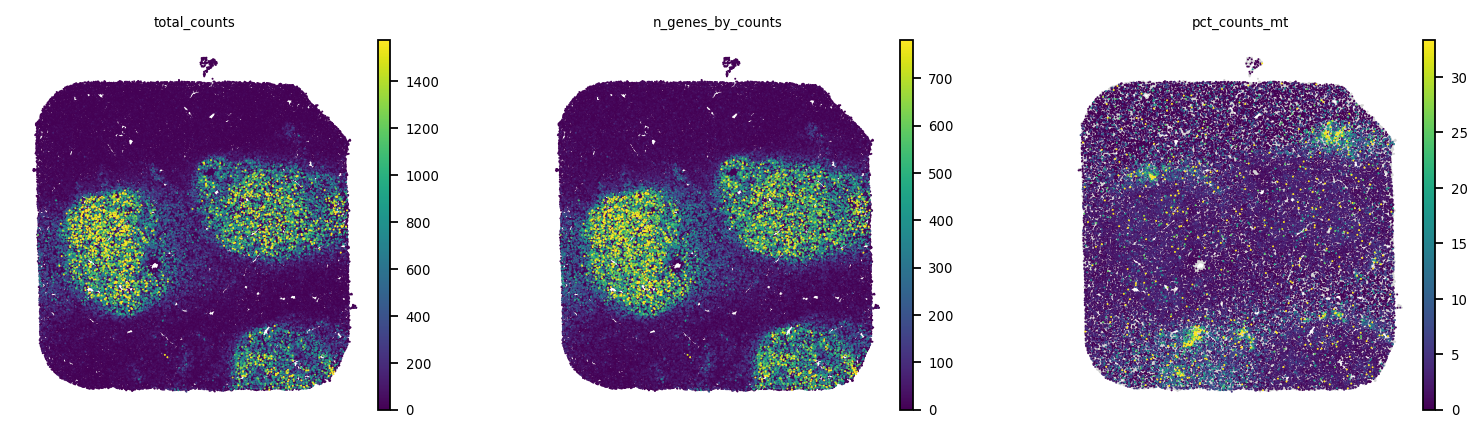

(78205, 31053)
PLN_Infected_D3PI: D3
(174825472, 31053)
(78475, 3)
PLN_Infected_D3PI


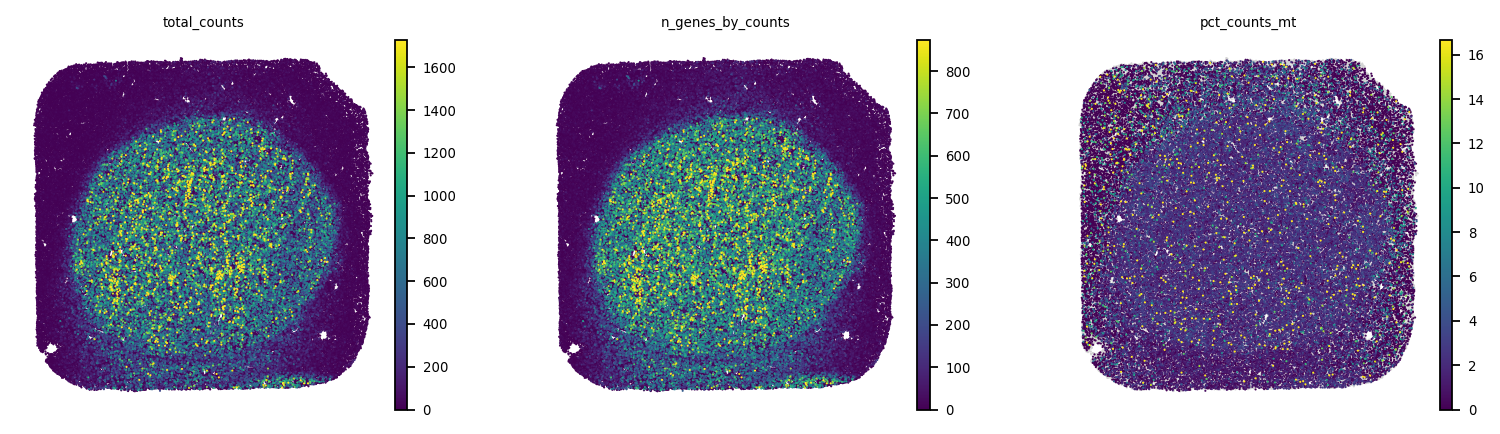

(78462, 31053)
D7_sample1_07242023: D7
(169884624, 31053)
(77252, 3)
D7_sample1_07242023


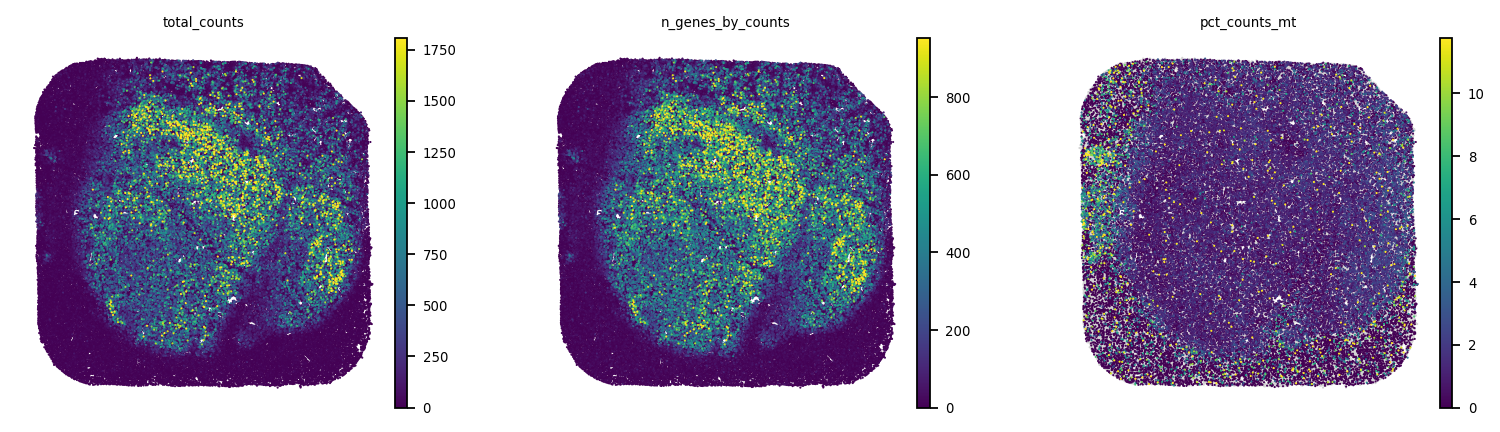

(77245, 31053)
D10_sample2_07242023: D10
(173992455, 31053)
(78572, 3)
D10_sample2_07242023


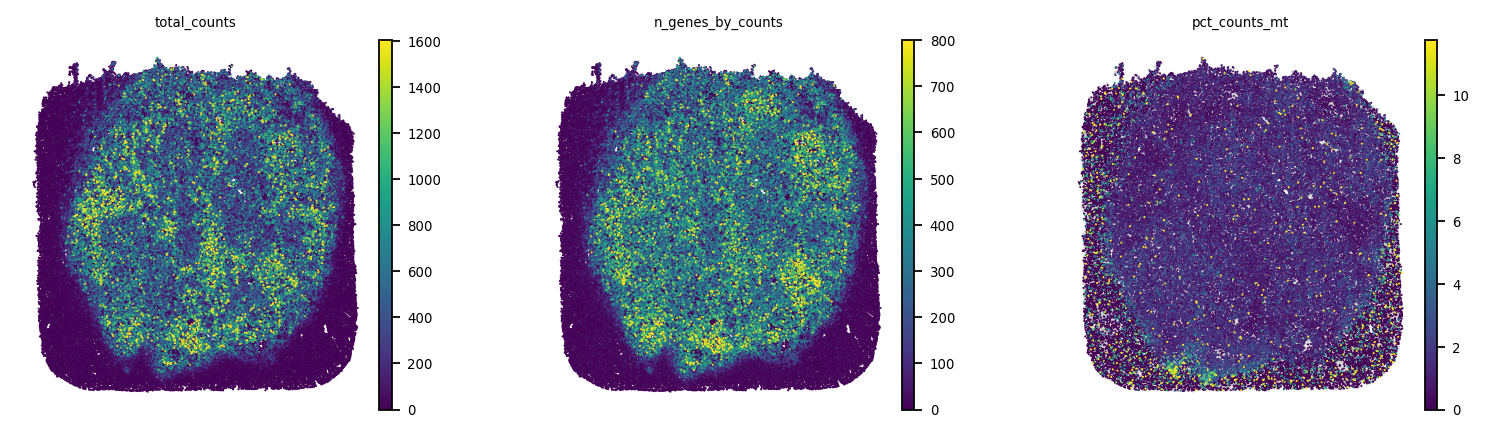

(78558, 31053)
D14_sample2_07242023: D14
(172904448, 31053)
(78234, 3)
D14_sample2_07242023


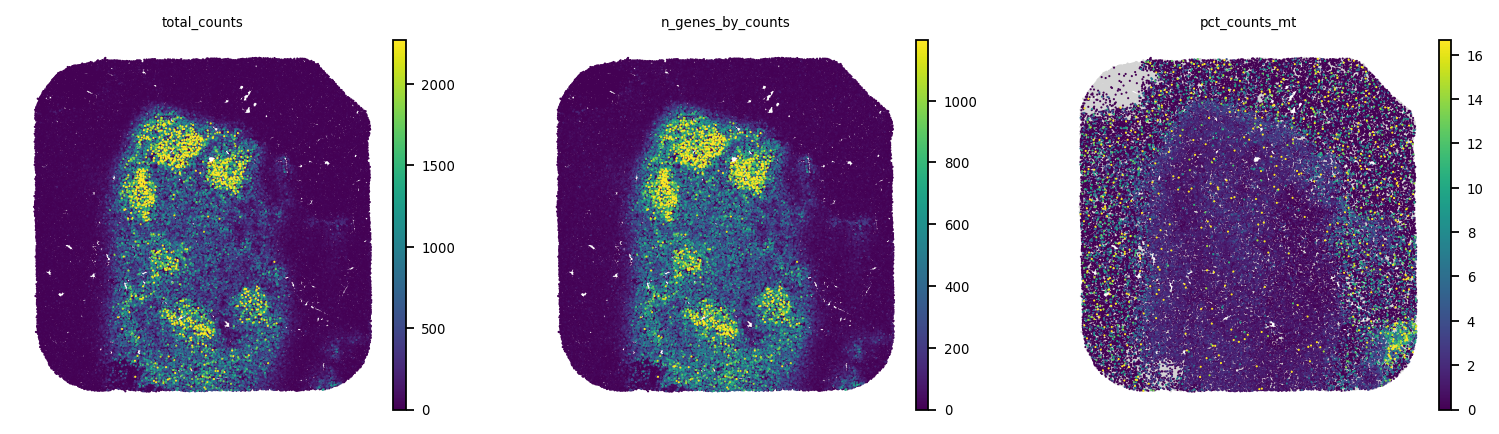

(78224, 31053)
D21_sample_112023: D21
(173850175, 31053)
(79428, 3)
D21_sample_112023


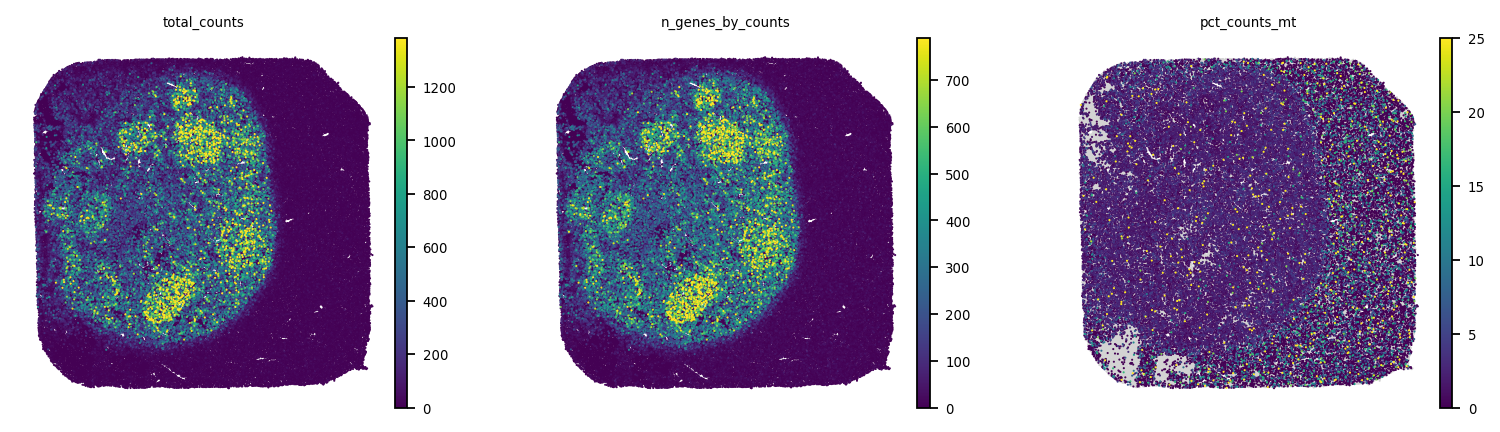

(79423, 31053)


In [6]:
# From STARsolo folders
samples_dict = {"PLN_Mock_D3PI":"Mock", "PLN_Infected_D3PI":"D3","D7_sample1_07242023":"D7", "D10_sample2_07242023":"D10",
                "D14_sample2_07242023":"D14","D21_sample_112023":"D21"}

for sample in samples_dict.keys():
        print(sample + ": " + samples_dict[sample])
        adata = sc.read_10x_mtx(path="../output_files/STARsolo_output/" + sample + "/STARsolo_output/Solo.out/Gene/raw/")
        print(adata.shape)
        adata.obs_names = [(''.join(x.split("_"))) for x in adata.obs_names]
        barcodes_adata = pd.read_csv("../slideseq_beadbarcodes/"+ samples_dict[sample] + "_BeadBarcodes.txt", delimiter="\t", names= ["barcode", "x", "y"])
        barcodes_adata[["x", "y"]].to_numpy()
        barcodes_adata.index = barcodes_adata["barcode"]
        print(barcodes_adata.shape)
        shared_barcodes_adata = list(set(adata.obs_names).intersection(set(barcodes_adata["barcode"])))
        adata = adata[shared_barcodes_adata]
        barcodes_adata = barcodes_adata.reindex(adata.obs_names)
        adata.obs = adata.obs.join(barcodes_adata)
        adata.obsm["spatial"] = barcodes_adata[["x", "y"]].to_numpy()
        adata.obs_names_make_unique()
        adata.var_names_make_unique()

        adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

        sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(3.0,3.0), facecolor='white', frameon=False, transparent=True, format="pdf")
        print(sample)
        sc.pl.spatial(
                adata,
                color= ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
                spot_size=30, vmin=0, vmax='p99.2')
        sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
        print(adata.shape)
        adata.write_h5ad("../output_files/objects/adata_"+ samples_dict[sample]+ "_with_image_raw_counts.h5ad")

## II. Scanpy filtered h5ad objects

In [ ]:
adata_dict = dict()
for sample in samples_dict.keys():
        adata_dict[sample] = sc.read_h5ad("../output_files/objects/adata_"+ samples_dict[sample]+ "_with_image_raw_counts.h5ad")
adata_dict

for sample in adata_dict.keys():
        print(sample)
        # Mock and D3PI would be different filter step
        if sample in ["PLN_Mock_D3PI","PLN_Infected_D3PI"]:
                sc.pp.filter_cells(adata_dict[sample], min_counts=150)
        else:
                sc.pp.filter_cells(adata_dict[sample], min_counts=100) # 150 would filter too many        
        
        print(adata_dict[sample].shape)
        sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(3.0,3.0), facecolor='white', frameon=False, transparent=True, format="pdf")

# remove smear
for sample in adata_dict.keys():
    adata_dict[sample].obsm["spatial_distances"] = scisp.distance.squareform(scisp.distance.pdist(adata_dict[sample].obsm['spatial']))
    adata_dict[sample].obs["spatial_neighbors_100_true"] = np.sum(adata_dict[sample].obsm["spatial_distances"] < 100, axis=0)
for sample in adata_dict.keys():
    adata_dict[sample] = adata_dict[sample][adata_dict[sample].obs['spatial_neighbors_100_true'] >= 15, ]

In [9]:
# load the filtered objects
samples_dict = {"PLN_Mock_D3PI":"Mock", "PLN_Infected_D3PI":"D3","D7_sample1_07242023":"D7", "D10_sample2_07242023":"D10",
                "D14_sample2_07242023":"D14","D21_sample_112023":"D21"}
adata_dict = dict()
for sample in samples_dict.keys():
        adata_dict[samples_dict[sample]] = sc.read_h5ad("../output_files/objects/adata_"+ samples_dict[sample]+ "_with_image_raw_counts_filtered_smear_removed.h5ad")
adata_dict

{'Mock': AnnData object with n_obs × n_vars = 10256 × 31053
     obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'spatial_neighbors_100_true'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     obsm: 'spatial', 'spatial_distances',
 'D3': AnnData object with n_obs × n_vars = 18661 × 31053
     obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     obsm: 'spatial',
 'D7': AnnData object with n_obs × n_vars = 26692 × 31053
     obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'spatial_neighbors_100_true'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
   

In [10]:
adata_dict_cp = adata_dict.copy()

In [11]:
# all raw? Yes
# for sample in samples_dict.keys():
#     print(adata_dict[sample].X.sum())
for sample in adata_dict.keys():
    print(sample)
    if sample == "Mock":
        adata_dict[sample].obs['Sample'] = sample
    else:
        new_samp = sample
        new_samp = new_samp+"PI"
        adata_dict[sample].obs['Sample'] = new_samp
    adata_dict[sample].obs['Index'] = adata_dict[sample].obs['barcode']+'_'+adata_dict[sample].obs['Sample']

Mock
D3
D7
D10
D14
D21


In [13]:
adata_comb = sc.concat(
    list(adata_dict.values()), 
    join='outer',              # or 'inner', depending on how you want to handle missing genes
    # label='batch',            # column in .obs that will store which batch/sample each cell is from
    # keys=list(adata_dict.keys())
)
adata_comb.obs
adata_comb.obs.index = adata_comb.obs['Index']
# save
# adata_comb.write_h5ad("../../../output_files/objects/adata_comb_allTP_whole_meta_raw.h5ad")

/home/sj657/miniconda3/envs/c2l_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


barcode       x       y  n_genes_by_counts  \
TCACTGCCGGTGGC  TCACTGCCGGTGGC  4906.9  2672.2                493   
AGACTCTACGCGGG  AGACTCTACGCGGG  2439.5  3825.3                425   
GGCTGCTGCCCAGC  GGCTGCTGCCCAGC  3927.0  2598.0                596   
TGTCTTATTGACTC  TGTCTTATTGACTC  4389.0  1892.0                662   
CTAATGTTACTAGT  CTAATGTTACTAGT  3971.0  1723.8                236   
...                        ...     ...     ...                ...   
TACCTTCCTTCTCA  TACCTTCCTTCTCA   780.2  3969.8                253   
TAGACAAAATACAT  TAGACAAAATACAT  2619.0  3229.7                397   
GTCAGATTCGTTGG  GTCAGATTCGTTGG  2502.2  4370.5                575   
TCCTCCAATCTAGA  TCCTCCAATCTAGA  3185.1  2663.9                188   
TTCGGCTCTTCCGA  TTCGGCTCTTCCGA  3353.8  3311.6                600   

                total_counts  total_counts_mt  pct_counts_mt  n_counts  \
TCACTGCCGGTGGC        1067.0             47.0       4.404873    1067.0   
AGACTCTACGCGGG         643.0             16.0       2.488336     643.0   
GGCTGCTGCCCAGC        1157.0             34.0       2.938634    1157.0   
TGTCTTATTGACTC        1269.0             24.0       1.891253    1269.0   
CTAATGTTACTAGT         317.0              3.0       0.946372     317.0   
...                      ...              ...            ...       ...   
TACCTTCCTTCTCA         373.0              5.0       1.340483     373.0   
TAGACAAAATACAT         633.0             13.0       2.053713     633.0   
GTCAGATTCGTTGG         974.0             12.0       1.232033     974.0   
TCCTCCAATCTAGA         259.0              9.0       3.474904     259.0   
TTCGGCTCTTCCGA         947.0             11.0       1.161563     947.0   

                spatial_neighbors_100_true Sample                 Index  
TCACTGCCGGTGGC                        50.0   Mock   TCACTGCCGGTGGC_Mock  
AGACTCTACGCGGG                        52.0   Mock   AGACTCTACGCGGG_Mock  
GGCTGCTGCCCAGC                        63.0   Mock   GGCTGCTGCCCAGC_Mock  
TGTCTTATTGACTC                        61.0   Mock   TGTCTTATTGACTC_Mock  
CTAATGTTACTAGT                        51.0   Mock   CTAATGTTACTAGT_Mock  
...                                    ...    ...                   ...  
TACCTTCCTTCTCA                        23.0  D21PI  TACCTTCCTTCTCA_D21PI  
TAGACAAAATACAT                        49.0  D21PI  TAGACAAAATACAT_D21PI  
GTCAGATTCGTTGG                        70.0  D21PI  GTCAGATTCGTTGG_D21PI  
TCCTCCAATCTAGA                        67.0  D21PI  TCCTCCAATCTAGA_D21PI  
TTCGGCTCTTCCGA                        69.0  D21PI  TTCGGCTCTTCCGA_D21PI  

[133826 rows x 11 columns]

# 2. Multilevel Cell-Type Label Assignment with cell2location

## I. Download the single-cell RNA-seq reference from c2l paper and convert to mouse gene symbols

In [ ]:
# Read data 
# code from https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)
# conversion package: mousipy
from mousipy import translate
micy_adata = translate(adata_ref)
# save
micy_adata.write_h5ad("../Data/scRNAseq_reference/Human_LN_Mouse_convertscRNAseq_ref_c2l.h5ad")

In [ ]:
# combine to save together into a single object
adata_comb = sc.read_h5ad("../output_files/objects/adata_comb_allTP_whole_meta_raw.h5ad")
adata_comb.obs

## II. Cell2location process: scRNA-seq reference model

In [ ]:
## modify the cell type labels, merge some of the subtypes
adata_ref = sc.read_h5ad("../Data/scRNAseq_reference/Human_LN_Mouse_convertscRNAseq_ref_c2l.h5ad")
adata_ref.obs['mod_celltype'] = adata_ref.obs['Subset'].astype(str)
# adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['DC_CCR7+','DC_pDC','DC_cDC1']),'mod_celltype'] = "DCs"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['B_GC_LZ','B_GC_DZ','B_preGC','B_GC_prePB']),'mod_celltype'] = "B_GC"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['B_activated','B_naive']),'mod_celltype'] = "B_naive"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['T_CD4+_naive','T_CD4+','T_CD8+_naive','T_CD4+_TfH','T_CD4+_TfH_GC']),'mod_celltype'] = "T_CD4+"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['T_CD8+_cytotoxic','T_CD8+_CD161+','T_CD8+_naive']),'mod_celltype'] = "T_CD8+"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['T_Treg','T_TfR']),'mod_celltype'] = "T_reg"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['Macrophages_M1','Macrophages_M2']),'mod_celltype'] = "Macrophage"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['NK','NKT','ILC']),'mod_celltype'] = "NK_ILC"
adata_ref.obs.loc[adata_ref.obs['mod_celltype'].isin(['DC_cDC1','DC_cDC2','DC_pDC','DC_CCR7+']),'mod_celltype'] = "DCs"
# And get the T_cycling out
adata_ref.obs.loc[adata_ref.obs['PrelimCellType_new']=='T_Cycling','mod_celltype'] = "T_Cycling"
# Not sure about what is B_IFN, T_TIM3+ & Mast cell is too few
adata_ref = adata_ref[~adata_ref.obs['mod_celltype'].isin(['B_IFN','Mast','T_TIM3+'])]

adata_ref.obs['mod_celltype'].value_counts()

In [ ]:
# for running cell2location, we need a GPU
###!!! c2l process
micy_adata = adata_ref.copy()
# use GPU: cluster3
from cell2location.utils.filtering import filter_genes
selected = filter_genes(micy_adata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
micy_adata = micy_adata[:, selected].copy()
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=micy_adata,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='mod_celltype',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )
from cell2location.models import RegressionModel
mod = RegressionModel(micy_adata)

# view anndata_setup as a sanity check
mod.view_anndata_setup()
mod.train(max_epochs=500, use_gpu=3)
mod.plot_history(20)
# save the module
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
micy_adata = mod.export_posterior(
    micy_adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': 3}
)

# Save model
mod.save("../output_files/objects/Human_LN_mod_celltype_convert_mouse_cell2location_sc_ref_mod", overwrite=True)
# Save anndata object with results
micy_adata.write("../output_files/objects/Human_LN_mod_celltype_sc_ref_convert_mouse.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in micy_adata.varm.keys():
    inf_aver = micy_adata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in micy_adata.uns['mod']['factor_names']]].copy()
else:
    inf_aver = micy_adata.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in micy_adata.uns['mod']['factor_names']]].copy()
inf_aver.columns = micy_adata.uns['mod']['factor_names']
print(inf_aver.shape)

## III. c2l spatial mapping

In [ ]:
adata_tmp = adata_comb.copy()
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_tmp.var_names, inf_aver.index)
print(len(intersect))
# save raw
# adata_tmp.raw = adata_tmp
adata_tmp = adata_tmp[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# c2l process
cell2location.models.Cell2location.setup_anndata(adata = adata_tmp,batch_key='Sample')
# create and train the model
mod = cell2location.models.Cell2location(
    adata_tmp, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1, # should I set up higher, same as cell2loc papaer, set to 1
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=5000,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size= 1.0,
          # batch?
          use_gpu=3)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training']);

adata_tmp.obs.index = adata_tmp.obs['Index']
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_tmp = mod.export_posterior(
    adata_tmp, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
# mod.save("./../pyobjs/Human_LN_c2l_modcelltype_ss_D21_mod_0122", overwrite=True)

# Save anndata object with results
adata_tmp.write("../output_files/objects/adata_allTP_c2l_Human_LN_mod_celltype_0122_batch.h5ad")

In [ ]:
## Further cluster on Abundance matrix
# abundance
adata_tmp.obs[adata_tmp.uns['mod']['factor_names']] = adata_tmp.obsm['q05_cell_abundance_w_sf']
new_vis = ad.AnnData(X = adata_tmp.obs[adata_tmp.uns['mod']['factor_names']], obs = adata_tmp.obs) # this is abundance
new_vis.obsm['spatial'] = adata_tmp.obsm['spatial']
sc.pp.neighbors(new_vis, n_neighbors=30)
sc.tl.umap(new_vis)
sc.tl.leiden(new_vis, key_added="leiden_0.8_cell2loc_prob", resolution = 0.8)
resolution=0.8
sc.tl.rank_genes_groups(new_vis, ('leiden_'+str(resolution)+'_cell2loc_prob'), method='wilcoxon', key_added=('rank_genes_groups_leiden_'+str(resolution)))
# # plot
# sc.pl.rank_genes_groups(new_vis, n_genes = 10, key=('rank_genes_groups_leiden_'+str(resolution)),fontsize = 15, ncols = 5)
allclusters = new_vis.obs[('leiden_'+str(resolution)+'_cell2loc_prob')].unique()
# temp_df = sc.get.rank_genes_groups_df(new_bl_vis)
dflist = []
for i in allclusters:
    print(i)
    temp_df = sc.get.rank_genes_groups_df(new_vis, group = i, key = ('rank_genes_groups_leiden_'+str(resolution))) # make sure it is positive
    temp_df['cluster'] = i
    dflist.append(temp_df.iloc[0:1,:])
de_cetype = pd.concat(dflist)
# Assign cell type labels
# Let's check how it looks like
celltypes = {k : v for k,v in zip(de_cetype['cluster'], de_cetype['names'])}
new_vis.obs['celltype_c2l_clust_abundance'] = new_vis.obs[('leiden_'+str(resolution)+'_cell2loc_prob')].map(celltypes).astype("category")
new_vis.obs['celltype_c2l_clust_abundance'].value_counts()
# convert to adata_vis object
adata_tmp.obs["celltype_c2l_abun_leiden_0.8"] = new_vis.obs["celltype_c2l_clust_abundance"].astype(str)
# B_naive and B_mem are too ambiguous
adata_tmp.obs['celltype_c2l_abun_leiden_0.8'] = adata_tmp.obs['celltype_c2l_abun_leiden_0.8'].astype(str)
adata_tmp.obs.loc[adata_tmp.obs['celltype_c2l_abun_leiden_0.8'].isin(["B_mem","B_naive"]),"celltype_c2l_abun_leiden_0.8"] = "B_cells" 

In [ ]:
# Broad cell type
broad_celltype_dict = {"B cell follicles" : ["B_GC","B_Cycling"],
                       "B cells" : ['B_mem','B_naive'],
                       "T cells": ["T_Cycling","T_CD4+","T_reg","T_CD8+"],
                       "Myeloid": ["Macrophage","Monocytes","DCs"],
                       "Endothelium": ["VSMC","Endo"]}
adata_tmp.obs['broad_celltype_c2l_abun_leiden_0.8'] = adata_tmp.obs['celltype_c2l_abun_leiden_0.8'].astype(str) 
for key,value in broad_celltype_dict.items():
    adata_tmp.obs.loc[adata_tmp.obs['broad_celltype_c2l_abun_leiden_0.8'].isin(value),'broad_celltype_c2l_abun_leiden_0.8'] = key

adata_tmp.obs['broad_celltype_c2l_abun_leiden_0.8'].value_counts(dropna=False)
# save
## drop columns
adata_tmp.obs = adata_tmp.obs.drop(columns = ['celltype_prob','celltype_c2l_prob_leiden_1.2','Cycling_celltypes','Celltypes','_indices', '_scvi_batch', '_scvi_labels', 'total_abundance', 'B_Cycling', 'B_GC', 'B_mem', 'B_naive', 'B_plasma', 'DCs', 'Endo', 'FDC', 'Macrophage', 'Monocytes', 'NK_ILC', 'T_CD4+', 'T_CD8+', 'T_Cycling', 'T_reg', 'VSMC','celltype_c2l_prob_leiden_0.8'])
# save
adata_tmp.write_h5ad("../output_files/objects/adata_allTP_c2l_Human_LN_mod_celltype_0122_batch_clust_abundance.h5ad")

## IV. Reannotate to extract the Adipose cluster

In [ ]:
adata_comb = sc.read_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_raw.h5ad")
sc.pp.normalize_total(adata_comb, inplace=True)
sc.pp.log1p(adata_comb)
sc.pp.highly_variable_genes(adata_comb, max_mean=3, min_disp=0.20)
sc.pl.highly_variable_genes(adata_comb)
adata_comb = adata_comb[:, adata_comb.var.highly_variable]
print(adata_comb.shape)
sc.pp.regress_out(adata_comb, ["total_counts"])
sc.pp.scale(adata_comb, max_value=10)
sc.pp.pca(adata_comb, random_state= 0)
sc.pl.pca_variance_ratio(adata_comb, n_pcs = 50)

In [ ]:
sce.pp.harmony_integrate(adata_comb, 'Sample')
sc.pp.neighbors(adata_comb, use_rep= "X_pca_harmony",n_pcs=15)
sc.tl.umap(adata_comb)
sc.tl.leiden(adata_comb,resolution=1.0,key_added="harmony_leiden_1.0")
sc.tl.rank_genes_groups(adata_comb, 'harmony_leiden_1.0',method = "wilcoxon")
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(10, 7),fontsize=25)
sc.pl.rank_genes_groups(adata_comb, n_genes=15, sharey=False,fontsize=20,ncols=4)

In [ ]:
# cluster 9 & 4 on leiden 1.0
# changing
adata_comb.obs[['Celltypes','Broad_celltypes']] = adata_comb.obs[['Celltypes','Broad_celltypes']].astype(str)
adata_comb.obs.loc[adata_comb.obs['harmony_leiden_1.0'].isin(['4','9']),'Celltypes'] = "Adipocytes"
adata_comb.obs.loc[adata_comb.obs['harmony_leiden_1.0'].isin(['4','9']),'Broad_celltypes'] = "Endothelium"
# Change Endothelium to Stromal for better annotation
adata_comb.obs.loc[adata_comb.obs['Broad_celltypes'].isin(['Endothelium']),'Broad_celltypes'] = "Stroma"

In [ ]:
# save
adata_tmp = sc.read_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_raw.h5ad")
adata_tmp.obs[['Celltypes','Broad_celltypes']] = adata_tmp.obs[['Celltypes','Broad_celltypes']].astype(str)
adata_tmp.obs[['harmony_leiden_1.0','Celltypes','Broad_celltypes']] = adata_comb.obs[['harmony_leiden_1.0','Celltypes','Broad_celltypes']]
adata_tmp.write_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_raw.h5ad")

## V. Refine T cell subtypes

In [ ]:
# read the original one
adata_comb = sc.read_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_memsec_raw.h5ad")
adata_t = adata_comb[adata_comb.obs['Broad_celltypes']=="T cells"]
# for single-cell reference, load the Lopez one
adata_sc = sc.read_h5ad("../output_files/objects/scRNAseq_reference/DestVI_scRNA_LN_compressed.h5ad")
adata_sc_t = adata_sc[adata_sc.obs['broad_cell_types'].isin(['CD8 T cells','CD4 T cells','Tregs'])]
adata_sc_t.obs
## Build the Reference model
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_sc_t, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)
# %notebook filter the object
adata_sc_t = adata_sc_t[:, selected].copy()

# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_sc_t,
                        # 10X reaction / sample / batch
                        batch_key='batch',
                        # cell type, covariate used for constructing signatures
                        labels_key='broad_cell_types',categorical_covariate_keys=['MS'])
from cell2location.models import RegressionModel
mod = RegressionModel(adata_sc_t)

# view anndata_setup as a sanity check
mod.view_anndata_setup()
mod.train(max_epochs=700, use_gpu=3)
mod.plot_history(20)
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_sc_t = mod.export_posterior(
    adata_sc_t, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
# mod.save("./../pyobjs/LN_destvi_mod_celltype_cell2location_sc_T_celltype", overwrite=True)
adata_sc_t.obs = adata_sc_t.obs[['cell_types','batch','n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','MS','broad_cell_types','_indices','_scvi_batch','_scvi_labels']]
# Save anndata object with results
adata_sc_t.write("../output_files/objects/LN_destvi_mod_celltype_cell2location_sc_T_celltype.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc_t.varm.keys():
    inf_aver = adata_sc_t.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc_t.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc_t.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc_t.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc_t.uns['mod']['factor_names']
print(inf_aver.shape)

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_t.var_names, inf_aver.index)
print(len(intersect))
# save raw
# adata_tmp.raw = adata_tmp
adata_tmp = adata_t[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
## Spatial mapping
cell2location.models.Cell2location.setup_anndata(adata = adata_tmp,batch_key='Sample')
# create and train the model
mod = cell2location.models.Cell2location(
    adata_tmp, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1, # should I set up higher, same as cell2loc papaer, set to 1
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=5000,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size= 1.0,
          # batch?
          use_gpu=3)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training']);
# running
adata_tmp.obs.index = adata_tmp.obs['Index']
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_tmp = mod.export_posterior(
    adata_tmp, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)
# Save anndata object with results
adata_tmp.write("../output_files/objects/adata_Tcell_allTP_c2l_DestVI_LN_Feb2024_batch.h5ad")
# Assign cell type based on the max proportion
print(adata_tmp.obsm)
adata_tmp.obsm['q05_cell_proportions'] = adata_tmp.obsm['q05_cell_abundance_w_sf'].div(adata_tmp.obsm['q05_cell_abundance_w_sf'].sum(axis=1), axis=0)
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_tmp.obs["total_abundance"] = adata_tmp.obsm['q05_cell_abundance_w_sf'].sum(axis = 1)
adata_tmp.obs[adata_tmp.uns['mod']['factor_names']] = adata_tmp.obsm['q05_cell_proportions']
ct_list = list(adata_tmp.uns['mod']['factor_names'])
adata_tmp.obs["max_pred"] = adata_tmp.obs[adata_tmp.uns['mod']['factor_names']].max(axis=1)
adata_tmp.obs["max_pred_celltype"] = adata_tmp.obs[adata_tmp.uns['mod']['factor_names']].idxmax(axis=1)
# Merge Tregs to CD4 T cells
adata_tmp.obs['CD4_CD8_type'] = adata_tmp.obs['max_pred_celltype'].astype(str)
adata_tmp.obs['CD4_CD8_type'].replace("Tregs","CD4 T cells", inplace = True)
# save
adata_tmp.write_h5ad("../output_files/objects/adata_Tcells_allTP_c2l_HumanLN_mergTreg.h5ad")
# read the original one
adata_comb = sc.read_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_memsec_raw.h5ad")
adata_comb.obs.index = adata_comb.obs['Index']
transfer_df = adata_tmp.obs[['CD4_CD8_type']]
adata_comb.obs = adata_comb.obs.join(transfer_df, how = "left")
adata_comb.obs['Refine_celltypes'] = adata_comb.obs['Celltypes'].astype(str)
adata_t = adata_comb[adata_comb.obs['Broad_celltypes']=="T cells"]
adata_t.obs.groupby(['Celltypes','CD4_CD8_type']).size()
# chage
adata_comb.obs.loc[adata_comb.obs['Broad_celltypes']=="T cells", "Refine_celltypes"] = adata_comb.obs['CD4_CD8_type']
adata_comb.obs.loc[adata_comb.obs['Celltypes']=="T_Cycling", "Refine_celltypes"] = adata_comb.obs['CD4_CD8_type'].astype(str) + "_Cycling"
# rename
adata_comb.obs['Refine_celltypes'].replace("CD4 T cells_Cycling","T_CD4_Cycling",inplace=True)
adata_comb.obs['Refine_celltypes'].replace("CD8 T cells_Cycling","T_CD8_Cycling",inplace=True)
adata_comb.obs['Refine_celltypes'].replace("CD4 T cells","T_CD4",inplace=True)
adata_comb.obs['Refine_celltypes'].replace("CD8 T cells","T_CD8",inplace=True)
# save
adata_comb.write_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2lT_memsec_raw.h5ad")

## VI. Refine B cell subtypes

In [ ]:
nbc = sc.read_h5ad("../Data/scRNAseq_reference/HumanTonsilAtlas/NBC_MBC.h5ad")
nbc = nbc.raw.to_adata()
gcb = sc.read_h5ad("../Data/scRNAseq_reference/HumanTonsilAtlas/GCBC.h5ad")
gcb = gcb.raw.to_adata()
pc = sc.read_h5ad("../Data/scRNAseq_reference/HumanTonsilAtlas/PC.h5ad")
pc = pc.raw.to_adata()
# concatenate
adata_ref = ad.concat([nbc,gcb,pc])
# remove the NA
adata_ref = adata_ref[adata_ref.obs['annotation_figure_1']!="NA"]
# Convert to mouse genes
adata_ref = translate(adata_ref)
adata_ref.write_h5ad("../Data/scRNAseq_reference/HumanTonsilAtlas/AllBC_HTA_convert_mouse.h5ad")
## Build the reference model
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='donor_id',
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation_figure_1',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['age_group','sex','hospital']
                       )
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()
mod.train(max_epochs=500, use_gpu=1)
mod.plot_history(20)
# save
# save the module
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': 1}
)

# Save model
# mod.save("./../pyobjs/HTA_AllBC_convert_mouse_cell2location_sc_ref_mod", overwrite=True)
adata_ref.write("../Data/scRNAseq_reference/AllBC_HTA_convert_mouse.h5ad")
# read the mod and object
adata_ref = sc.read_h5ad("../Data/scRNAseq_reference/AllBC_HTA_convert_mouse.h5ad")
# mod = cell2location.models.RegressionModel.load("./../pyobjs/HTA_AllBC_convert_mouse_cell2location_sc_ref_mod", adata_ref)
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
print(inf_aver.shape)
## Spatial mapping
adata_comb = sc.read_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2l_memsec_raw.h5ad")
# adata_b = adata_comb[adata_comb.obs['Broad_celltypes'].isin(["B_plasma","B cell follicles","B cells"])]
adata_b = adata_comb[adata_comb.obs['Celltypes'].isin(["B_plasma","B_Cycling","B_cells","B_GC","Adipocytes"])]
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_b.var_names, inf_aver.index)
print(len(intersect))
# save raw
# adata_tmp.raw = adata_tmp
adata_tmp = adata_b[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
cell2location.models.Cell2location.setup_anndata(adata = adata_tmp,batch_key='Sample')
# create and train the model
mod = cell2location.models.Cell2location(
    adata_tmp, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1, # should I set up higher, same as cell2loc papaer, set to 1
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=5000,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size= 1.0,
          # batch?
          use_gpu=1)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training']);
# running
adata_tmp.obs.index = adata_tmp.obs['Index']
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_tmp = mod.export_posterior(
    adata_tmp, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)
# Save anndata object with results
# adata_tmp.write("./../pyobjs/adata_Bcell_allTP_c2l_HTAallB_Feb2024_batch.h5ad")
adata_tmp.write("../output_files/objects/adata_AdiBcell_allTP_c2l_HTAallB_Feb2024_batch.h5ad")

adata_tmp = sc.read_h5ad("../output_files/objects/adata_AdiBcell_allTP_c2l_HTAallB_Feb2024_batch.h5ad")
# Further cluster on abundance with resolution of 0.5
adata_tmp.obs[adata_tmp.uns['mod']['factor_names']] = adata_tmp.obsm['q05_cell_abundance_w_sf']
new_vis = ad.AnnData(X = adata_tmp.obs[adata_tmp.uns['mod']['factor_names']], obs = adata_tmp.obs) # this is abundance
new_vis.obsm['spatial'] = adata_tmp.obsm['spatial']
sc.pp.neighbors(new_vis, n_neighbors=30)
resolution = 0.5
# on proportion?
sc.tl.leiden(new_vis, key_added="leiden_"+str(resolution)+"_cell2loc_prob", resolution = resolution)
sc.tl.rank_genes_groups(new_vis, ('leiden_'+str(resolution)+'_cell2loc_prob'), method='wilcoxon', key_added=('rank_genes_groups_leiden_'+str(resolution)))
# # plot
# sc.pl.rank_genes_groups(new_vis, n_genes = 10, key=('rank_genes_groups_leiden_'+str(resolution)),fontsize = 15, ncols = 5)
allclusters = new_vis.obs[('leiden_'+str(resolution)+'_cell2loc_prob')].unique()
# temp_df = sc.get.rank_genes_groups_df(new_bl_vis)
dflist = []
for i in allclusters:
    print(i)
    temp_df = sc.get.rank_genes_groups_df(new_vis, group = i, key = ('rank_genes_groups_leiden_'+str(resolution))) # make sure it is positive
    temp_df['cluster'] = i
    dflist.append(temp_df.iloc[0:1,:])
de_cetype = pd.concat(dflist)
# de_cetype
celltypes = {k : v for k,v in zip(de_cetype['cluster'], de_cetype['names'])}
new_vis.obs['celltype_c2l_clust_abundance'] = new_vis.obs[('leiden_'+str(resolution)+'_cell2loc_prob')].map(celltypes).astype("category")
new_vis.obs['celltype_c2l_clust_abundance'].value_counts()
adata_tmp.obs['Bcelltype_c2l_abun_leiden_'+str(resolution)] = new_vis.obs["celltype_c2l_clust_abundance"].astype(str)

adata_tmp.obs['Bcell_subtype_abun'] = adata_tmp.obs['Bcelltype_c2l_abun_leiden_'+str(resolution)].astype(str)
transfer_df = adata_tmp.obs[['Bcell_subtype_abun']]
# change to a more consistant name
transfer_df.loc[transfer_df['Bcell_subtype_abun']=="GCBC",'Bcell_subtype_abun'] = "B_GC"
transfer_df.loc[transfer_df['Bcell_subtype_abun']=="PC",'Bcell_subtype_abun'] = "B_plasma"
transfer_df.loc[transfer_df['Bcell_subtype_abun']=="NBC",'Bcell_subtype_abun'] = "B_Naive"
transfer_df.loc[transfer_df['Bcell_subtype_abun']=="Activated NBC",'Bcell_subtype_abun'] = "B_Act_Naive"
transfer_df.loc[transfer_df['Bcell_subtype_abun']=="MBC",'Bcell_subtype_abun'] = "B_Mem"
adata_comb = sc.read_h5ad("../pyobjs/adata_allTP_demul_1lev_meta_c2lT_memsec_raw.h5ad")
adata_comb.obs = adata_comb.obs.join(transfer_df,how = 'left')
adata_comb.obs['Bcell_subtype_abun'].value_counts()
# change
adata_comb.obs['Refine_celltypes'] = adata_comb.obs['Refine_celltypes'].astype(str)
adata_comb.obs.loc[adata_comb.obs['Broad_celltypes'].isin(["B_plasma","B cell follicles","B cells"]),"Refine_celltypes"] = adata_comb.obs['Bcell_subtype_abun']
# save
adata_comb.write_h5ad("../output_files/objects/adata_allTP_demul_1lev_meta_c2lTB_memsec_raw.h5ad")

# 3. Bin Normalization

Bin size in 30um; leiden resolution in 0.7

In [ ]:
# Steps:
# Use higher resolution like 30um
adata_comb = sc.read_h5ad("/workdir/sj657/lymph_node/pyobjs/adata_allTP_demul_1lev_meta_c2lTB_memsec_ovpCS_raw.h5ad")
adata_comb.obs.index = adata_comb.obs['Index']
module_meta = pd.read_pickle("../genelist/ModuleScore_allTP_Goldrath_genes_individual_int.pickle")
adata_comb.obs = pd.concat([adata_comb.obs, module_meta], axis=1)
module_meta = pd.read_pickle("../genelist/ModuleScore_allTP_TNVMFL.pickle")
adata_comb.obs = pd.concat([adata_comb.obs, module_meta], axis=1)
module_meta = pd.read_pickle("../genelist/ModuleScore_allTP_ProjecTIL_geneset.pickle")
adata_comb.obs = pd.concat([adata_comb.obs, module_meta], axis=1)
sumdf = adata_comb.obs.describe()
cln = sumdf.columns.tolist()[6:]

In [ ]:
def bin_normalization(adata_comb, res=50,cln=cln):
    """
    bin them in 'res' units and add the cln to the bin data
    """
    bin_list = []
    for tp in ['Mock','D3PI','D7PI','D10PI','D14PI','D21PI']:
        print(tp)
        adata_tmp = adata_comb[adata_comb.obs['Sample']==tp]
        pixperbin = res*1.54
        # pixperbin = {10: 15.41, 20: 30.81, 40: 61.63, 50: 77.04, 100:154.08, 110: 169.49} # what is the value number mean??? the ratio is 1.54, maybe the scaling factor between the coordinates and the um
        x_min = np.min(adata_tmp.obs.x)
        x_max = np.max(adata_tmp.obs.x)
        y_min = np.min(adata_tmp.obs.y)
        y_max = np.max(adata_tmp.obs.y)
    
        xbins100 = np.arange(x_min, x_max, step = pixperbin)
        ybins100 = np.arange(y_min, y_max, step = pixperbin)
        # get centers for new coords
        xcoords100 = xbins100 + pixperbin/2.
        ycoords100 = ybins100 + pixperbin/2.
        # add final coordinate so next step works properly
        np.append(xbins100, x_max)
        np.append(ybins100, y_max)
        # get the coord matrix
        coords = adata_tmp.obs[['x','y']]
    
        coords100 = coords.copy()
        coords100['new_x'] = coords100.apply(lambda row: xcoords100[(np.argmax(xbins100 > row['x'])-1)] , axis=1)
        coords100['new_y'] = coords100.apply(lambda row: ycoords100[(np.argmax(ybins100 > row['y'])-1)] , axis=1)
        # should be false for both
        print(any(np.isnan(coords100.new_y)))
        print(any(np.isnan(coords100.new_x)))
        # call each bin by its whole num coords
        coords100['group'] = coords100.apply(lambda row: '{}_{}'.format(int(math.floor(row.new_x)), 
                                                                      int(math.floor(row.new_y))), axis = 1)
    
        # counts for 100, the raw counts from slide-seq
        counts_for100 = adata_tmp.to_df()
        # columns as genes, rows as cells
        # cell barcodes are in the same order as the coords100
        counts_for100['group'] = list(map(str, coords100['group']))
        # sum up the counts for same group
        counts100 = counts_for100.groupby('group').sum()
        counts100.reset_index(inplace=True)
        # set index as the group
        counts100 = counts100.set_index('group')
    
        ## add other numeric stat information
        # cln = ["num_ONT_reads","num_ONT_umi","num_align_umi","num_clones_IGH","num_clones_IGK","num_clones_IGL","num_clones_TRA","num_clones_TRB"]
        clones_for100 = adata_tmp.obs.loc[:,cln]
        # make Nan to 0.0
        clones_for100.replace(np.nan,0.0,inplace=True)
        clones_for100['group'] = list(map(str, coords100['group']))
        # sum up the counts for same group
        clones100 = clones_for100.groupby('group').sum()
        clones100.reset_index(inplace=True)
        # set index as the group
        clones100 = clones100.set_index('group')
    
        bin_mock = sc.AnnData(counts100,obs=clones100)
    
        # create another slide-seq object with the combined matrix
        new_coords100 = coords100[["group","new_x","new_y"]]
        new_coords100 = new_coords100.set_index("group")
        new_coords100 = new_coords100.drop_duplicates(("new_x","new_y"))
        new_coords100 = new_coords100.sort_index()
    
        bin_mock.obs = bin_mock.obs.join(new_coords100)
        bin_mock.obsm['spatial'] = new_coords100[["new_x","new_y"]].to_numpy()
        bin_mock.var['mt'] = bin_mock.var_names.str.startswith('mt-')
        # change the column name
        bin_mock.obs['num_IR_umi'] = bin_mock.obs['num_align_umi']
        sc.pp.calculate_qc_metrics(bin_mock, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        bin_mock.obs['Sample'] = tp
        bin_list.append(bin_mock)
    bin_comb = ad.concat(bin_list, join = "inner",index_unique="_", keys = ['Mock','D3PI','D7PI','D10PI','D14PI','D21PI'])
    return(bin_comb)

In [ ]:
# How about 30um
res = 30
bin_comb = bin_normalization(adata_comb,res = res)
bin_comb.write_h5ad("../pyobjs/adata_bin"+str(res)+"um_comb_raw_wLR.h5ad")
sc.pp.normalize_total(bin_comb)
sc.pp.log1p(bin_comb)
sc.pp.highly_variable_genes(bin_comb,min_disp=0.20,max_mean=5)
sc.pl.highly_variable_genes(bin_comb)
bin_comb.var.highly_variable.sum()
bin_comb.raw = bin_comb
bin_comb = bin_comb[:, bin_comb.var.highly_variable]
sc.pp.regress_out(bin_comb, ["total_counts"])
sc.pp.scale(bin_comb, max_value = 10)
sc.pp.pca(bin_comb, random_state= 0)
sc.pl.pca_variance_ratio(bin_comb, n_pcs = 50)
sce.pp.harmony_integrate(bin_comb, 'Sample')
sc.pp.neighbors(bin_comb, use_rep= "X_pca_harmony",n_pcs=20)
sc.tl.umap(bin_comb)
sc.tl.leiden(bin_comb,resolution=1.0,key_added="harmony_leiden_1.0")
sc.tl.leiden(bin_comb,resolution=0.8,key_added="harmony_leiden_0.8")
bin_comb.write_h5ad("../pyobjs/adata_bin"+str(res)+"um_comb_processed_wLR.h5ad")

In [ ]:
res = 0.7
g = "harmony_leiden_"+str(res)
sc.tl.leiden(bin_comb,resolution=res,key_added=g)
# for checking
sc.settings.set_figure_params(dpi=200, dpi_save= 200, fontsize=12, facecolor='white', frameon=False, figsize=(2, 2), vector_friendly = False, transparent=True, format="pdf")
sc.tl.dendrogram(bin_comb, "harmony_leiden_0.7")
sc.pl.correlation_matrix(bin_comb, "harmony_leiden_0.7", figsize=(7, 7))

In [ ]:
# 0.7
region_annotation = {'0': 'Outer Cortex',
                     '1': 'Inner Cortex',
                     '2': 'Capsule', #?
                     '3': 'Fat Tissue',
                     '4': 'Medulla', # later TP
                     '5': 'Trabeculae', #plasma
                     '6': 'Medulla', # early TP
                     '7': 'Inner Cortex',
                     '8': 'Germinal Center',
                     '9': 'Afferent lymph vessel',
                     '10': 'Germinal Center'}
bin_comb.obs['Region_Leiden_0.7'] = bin_comb.obs['harmony_leiden_0.7']
bin_comb.obs['Region_Leiden_0.7'] = bin_comb.obs['Region_Leiden_0.7'].map(region_annotation).astype("str")

In [ ]:
# Transfer the label to Anndata
def bin_coord(adata_comb, res=50):
    """
    """
    coords_list = []
    for tp in ['Mock','D3PI','D7PI','D10PI','D14PI','D21PI']:
        print(tp)
        adata_tmp = adata_comb[adata_comb.obs['Sample']==tp]
        pixperbin = res*1.54
        # pixperbin = {10: 15.41, 20: 30.81, 40: 61.63, 50: 77.04, 100:154.08, 110: 169.49} # what is the value number mean??? the ratio is 1.54, maybe the scaling factor between the coordinates and the um
        x_min = np.min(adata_tmp.obs.x)
        x_max = np.max(adata_tmp.obs.x)
        y_min = np.min(adata_tmp.obs.y)
        y_max = np.max(adata_tmp.obs.y)
    
        xbins100 = np.arange(x_min, x_max, step = pixperbin)
        ybins100 = np.arange(y_min, y_max, step = pixperbin)
        # get centers for new coords
        xcoords100 = xbins100 + pixperbin/2.
        ycoords100 = ybins100 + pixperbin/2.
        # add final coordinate so next step works properly
        np.append(xbins100, x_max)
        np.append(ybins100, y_max)
        # get the coord matrix
        coords = adata_tmp.obs[['x','y']]
    
        coords100 = coords.copy()
        coords100['new_x'] = coords100.apply(lambda row: xcoords100[(np.argmax(xbins100 > row['x'])-1)] , axis=1)
        coords100['new_y'] = coords100.apply(lambda row: ycoords100[(np.argmax(ybins100 > row['y'])-1)] , axis=1)
        # should be false for both
        print(any(np.isnan(coords100.new_y)))
        print(any(np.isnan(coords100.new_x)))
        # call each bin by its whole num coords
        coords100['group'] = coords100.apply(lambda row: '{}_{}'.format(int(math.floor(row.new_x)), 
                                                                      int(math.floor(row.new_y))), axis = 1)
        coords100['group'] = coords100['group']+'_'+tp
    
        coords_list.append(coords100)
    coords_comb = pd.concat(coords_list, join = "inner")
    return(coords_comb)

In [ ]:
coords_comb = bin_coord(adata_comb,res = 30)
coords_comb['Index'] = coords_comb.index
coords_comb = coords_comb[['group','Index']]
selec_column = ['harmony_leiden_0.7','Region_Leiden_0.7']
bin_meta = bin_comb.obs[selec_column]
# join
coords_comb = coords_comb.set_index('group').join(bin_meta, on = 'group',how = 'right')
# to pickle
coords_comb.to_pickle("../pyobjs/bin30um_comb_coords_HarmLeiden07.pkl")

In [ ]:
# Join with Anndata meta
adata_comb = sc.read_h5ad("/workdir/sj657/lymph_node/pyobjs/adata_allTP_demul_1lev_meta_c2lTB_memsec_ovpCS_raw.h5ad")
meta = coords_comb.join(meta.set_index('Index'), on = 'Index', how = 'right')
adata_comb.obs = meta.set_index("Index")
# write
adata_comb.write_h5ad("../pyobjs/adata_allTP_demul_1lev_meta_c2lTB_memsec_ovpCS_wRegion_raw.h5ad")
#output csv
adata_comb.obs.to_csv("../csv/adata_allTP_meta_demul_1lev_meta_c2lTB_memsec_ovpCS_wRegion_raw.tsv",sep='\t')

In [ ]:
# plot Region
region_color_dict = {"Trabeculae": "#AE05D2", #purple
              "Germinal Center": "#0028FF",
              "Outer Cortex": "#00A69B", #light green
              "Inner Cortex": "#006745", #green
              "Capsule": "#DF1F1F",
              "Afferent lymph vessel":"#000000",
              "Fat Tissue": "#843200",
              "Medulla": "#ED4915"
             }
g = "Region_Leiden_0.7"
sc.settings.set_figure_params(dpi=500, dpi_save= 500, fontsize=12, facecolor='white', frameon=False, figsize=(2, 2), vector_friendly = False, transparent=True, format="pdf")
fig, axs = plt.subplots(1,6, figsize = (14,4))
plt.subplots_adjust(wspace=0)
f1 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="Mock"], color = g,spot_size=35,  ax = axs[0],show=False,title="Mock",legend_loc=None,palette=region_color_dict)
f2 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="D3PI"], color =g,spot_size=35,  ax = axs[1],show=False,title="D3PI",legend_loc=None,palette=region_color_dict)
f3 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="D7PI"], color = g,spot_size=35,  ax = axs[2],show=False,title="D7PI",legend_loc=None,palette=region_color_dict)
f4 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="D10PI"], color =g,spot_size=35,  ax = axs[3], show=False, title="D10PI",legend_loc=None,palette=region_color_dict)
f5 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="D14PI"], color = g,spot_size=35,  ax = axs[4],show=False,title="D14PI",legend_loc=None,palette=region_color_dict)
f6 = sc.pl.spatial(adata_comb[adata_comb.obs['Sample']=="D21PI"], color = g,spot_size=35,  ax = axs[5],show=False,title="D21PI",legend_loc="right margin",palette=region_color_dict)
fig.suptitle(g)
plt.savefig('figures/sp_Region_'+g+'.png',dpi = 500,transparent=True)
plt.savefig('figures/sp_Region_'+g+'.pdf',dpi = 500,transparent=True)

In [14]:
adata_comb = sc.read_h5ad("../output_files/objects/adata_comb_allTP_whole_meta_raw.h5ad")

In [16]:
adata_comb.obs.columns

Index(['barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'Sample', 'Index', 'S_score',
       'G2M_score', 'phase', 'Celltypes_c2lLN', 'Broad_celltypes',
       'Refine_celltypes', 'CD4_CD8_type', 'Bcell_subtype_c2lHTA', 'Region',
       'num_ONT_reads', 'num_ONT_umi', 'num_align_reads', 'num_align_umi',
       'num_TRBC_reads', 'num_TRBC_umi', 'num_TRAC_reads', 'num_TRAC_umi',
       'num_IGKC_reads', 'num_IGKC_umi', 'num_IGLC_reads', 'num_IGLC_umi',
       'num_IGHM_reads', 'num_IGHM_umi', 'num_IGHD_reads', 'num_IGHD_umi',
       'num_IGHG1_reads', 'num_IGHG1_umi', 'num_IGHG2B_reads',
       'num_IGHG2B_umi', 'num_IGHG2C_reads', 'num_IGHG2C_umi',
       'num_IGHG3_reads', 'num_IGHG3_umi', 'num_IGHE_reads', 'num_IGHE_umi',
       'num_IGHA_reads', 'num_IGHA_umi', 'num_clones_IGH', 'num_clones_IGK',
       'num_clones_IGL', 'num_clones_TRA', 'num_clones_TRB', 'IGH_MutFreq',
       'IGK_MutFreq', 'IGL_MutFreq', 'TRA_MutFreq', 'TRB_MutFr